**Problem Overview**

Online product reviews provided by consumers who previously purchased products have become a major information source for consumers and marketers regarding product quality. Research has shown that consumer online product ratings reflect both the customers' experience with the product and the influence of others' ratings.

**Objective**

You are required to build a machine learning model to predict the product rating out of 5.

**Evaluation Criteria**

Submissions are evaluated using Root Mean Squared Error (MSE).

***Step 1: Import necessary libraries***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import copy
from textblob import TextBlob
from sklearn.utils import resample
from wordcloud import WordCloud
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***Step 2: Data Inspection***

In [ ]:
pr_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/product_ratings/train_set_label.csv" )
pr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uniq_id                                      7486 non-null   object 
 1   product_name                                 7486 non-null   object 
 2   manufacturer                                 7481 non-null   object 
 3   price                                        6417 non-null   object 
 4   number_available_in_stock                    5587 non-null   object 
 5   number_of_reviews                            7486 non-null   object 
 6   number_of_answered_questions                 6909 non-null   float64
 7   amazon_category_and_sub_category             7000 non-null   object 
 8   customers_who_bought_this_item_also_bought   6665 non-null   object 
 9   description                                  7013 non-null   object 
 10  

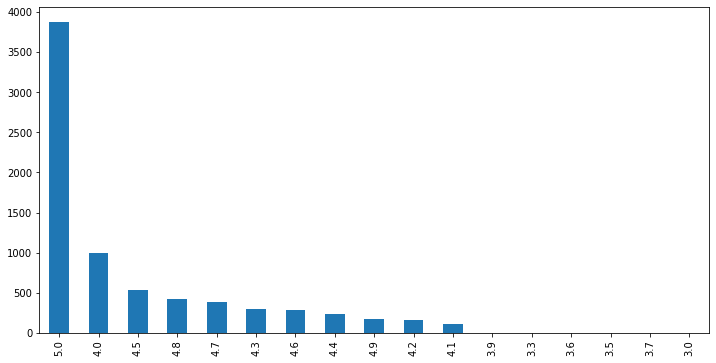

In [ ]:
pr_data["average_review_rating"].value_counts().plot(kind="bar",figsize=(12,6))

In [ ]:
#@title
nltk.download('stopwords')
words=stopwords.words("english")
len(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

***Step 3 : Clean the Text - Remove html tags,special characters,symbols and case conversion***

In [ ]:
import re
def clean_text(text):
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"can\'t","can not",text)
    text = re.sub(r"n\'t","not",text)
    text = re.sub(r"\'re","are",text)
    text = re.sub(r"\'s","is",text)
    text = re.sub(r"\'d","would",text)
    text = re.sub(r"\'ll","will",text)
    text = re.sub(r"\'t","not",text)
    text = re.sub(r"\'ve","have",text)
    text = re.sub("r\'m","am",text)
    text = text.replace("\\r"," ")
    text = text.replace("\\n"," ")
    text = text.replace('\\"',' ')
    text = re.sub("(@£[A-Za-z0-9]+)|([^A-Za-z0-9']+)|(\w+:\/\/S+)",' ',text)
    text = text.lower().strip()
    text = ' '.join(e for e in text.split() if e not in stopwords.words("english"))
    return text

In [ ]:
data = pr_data.copy() #create a copy
data.isna().sum() #check for missing values

uniq_id                                           0
product_name                                      0
manufacturer                                      5
price                                          1069
number_available_in_stock                      1899
number_of_reviews                                 0
number_of_answered_questions                    577
amazon_category_and_sub_category                486
customers_who_bought_this_item_also_bought      821
description                                     473
product_information                              45
product_description                             473
items_customers_buy_after_viewing_this_item    2307
customer_questions_and_answers                 6817
customer_reviews                                  3
sellers                                        2314
average_review_rating                             0
dtype: int64

**Drop the column customer_questions_and_answers as it contains lot of missing values.
Also drop description column as it is repeated again as product_description**

In [ ]:
data = data.drop(columns = ['customer_questions_and_answers'])
data = data.drop(columns = ['description'])

In [ ]:
data = data.dropna()

In [ ]:
data["number_of_reviews"] = data["number_of_reviews"].astype(str)
data.price = data.price.str.replace('[#,£,&]','') #Replace the price symbol by space.

In [ ]:
data["product_name"]= data["product_name"].apply(clean_text) # All the columns that contain text are cleaned using the defined function clean_text
data["manufacturer"]= data["manufacturer"].apply(clean_text)
data["amazon_category_and_sub_category"]= data["amazon_category_and_sub_category"].apply(clean_text)
data["customers_who_bought_this_item_also_bought"]= data["customers_who_bought_this_item_also_bought"].apply(clean_text)
data["product_description"]= data["product_description"].apply(clean_text)
data["product_information"]= data["product_information"].apply(clean_text)
data["sellers"] = data["sellers"].apply(clean_text)

**Combine the columns containing text into a single column named Review.**

In [ ]:
data['Review'] = (data['product_name'].map(str)+' '+data['manufacturer'].map(str) +' '+data['amazon_category_and_sub_category'].map(str)+' '+data['product_information'].map(str)+' '+data['product_description'].map(str)+' '+data['customer_reviews'].map(str)+' '+data['sellers']).apply(lambda row: row.strip())

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
w = WordNetLemmatizer()
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data.Review = data.Review.apply(lambda x: " ".join(w.lemmatize(word,'v') for word in x.split())) # Lemmatization

***Step 4: Building the Model***

In [ ]:
y = data['average_review_rating'] # Target column

In [ ]:
X = data[['Review']] 

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.20, random_state=42) # Split into 80% training and 20% test data

In [ ]:
print('Xtrain shape',Xtrain.shape) # Check for all the shapes
print('Xtest shape',Xtest.shape)
print('ytrain shape',ytest.shape)
print('ytest shape',ytest.shape)

In [ ]:
#@title
y

3       5.0
4       4.2
10      4.8
13      4.5
14      4.8
       ... 
7473    4.0
7476    4.0
7477    5.0
7479    5.0
7480    4.3
Name: average_review_rating, Length: 2062, dtype: float64

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import FunctionTransformer
get_data=FunctionTransformer(lambda x: x['Review'], validate=False)

In [ ]:
textdata=get_data.fit_transform(Xtrain)

In [ ]:
join_features = FeatureUnion(
            transformer_list = [
                ('text1_features', Pipeline([
                    ('selector', get_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )

In [ ]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [ ]:
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

In [ ]:
dec_tree =Pipeline([
        ('union', join_features),
        ('clf',DecisionTreeRegressor(random_state=0))
    ])

In [ ]:
ran_for = Pipeline([
        ('union', join_features),
        ('clf', RandomForestRegressor(n_estimators=10))
    ])

In [ ]:
extra_tree = Pipeline([
        ('union', join_features),
        ('clf', ExtraTreesRegressor(n_estimators=100, random_state=0))
    ])


In [ ]:
grad_boost = Pipeline([
        ('union', join_features),
        ('clf', GradientBoostingRegressor(random_state=0))
    ])

In [ ]:
knn= Pipeline([
        ('union', join_features),
        ('clf', KNeighborsRegressor())
    ])

In [ ]:
lin_reg = Pipeline([
        ('union', join_features),
        ('clf', LinearRegression())
    ])

In [ ]:
xgb_reg = Pipeline([
        ('union', join_features),
        ('clf', XGBRegressor())
    ])

In [ ]:
sgd_reg = Pipeline([
        ('union', join_features),
        ('clf', SGDRegressor())
    ])

In [ ]:
ridge_reg = Pipeline([
        ('union', join_features),
        ('clf', KernelRidge())
    ])

In [ ]:
elastic_reg = Pipeline([
        ('union', join_features),
        ('clf', ElasticNet())
    ])

In [ ]:
svc_reg = Pipeline([
        ('union', join_features),
        ('clf',SVR())
    ])

In [ ]:
Xtrain

,Review
4071,worlds apart flash 170cx kite worlds apart wor...
6966,orchard toy farmyard dominoes orchard toy game...
4983,christmas elf felt shoe adult fancy dress acce...
239,schmidt rummy travel schmidt game card game te...
6306,brainbox inventions green board game co game e...
...,...
6004,dragon shield standard sleeves black dragon sh...
3942,hama bead boy single pegboard 286 crazy grans ...
4046,schleich look smurf schleich figure playsets p...
4691,tobar 1 24 scale special edition ford mustang ...


In [ ]:
dec_tree.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test1 = dec_tree.predict(Xtest).round(1)

In [ ]:
ran_for.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test2 = ran_for.predict(Xtest).round(1)

In [ ]:
extra_tree.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test3 = extra_tree.predict(Xtest).round(1)

In [ ]:
grad_boost.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test4 = grad_boost.predict(Xtest).round(1)

In [ ]:
knn.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test5 = knn.predict(Xtest).round(1)
y_test5

array([4.9, 4.6, 4.8, 4.7, 4.8, 4.8, 5. , 4.3, 5. , 4.7, 4.6, 4.7, 4.7,
       4.5, 4.8, 4.7, 4.5, 5. , 4.5, 4.4, 5. , 4.7, 4.8, 4.7, 5. , 4.8,
       4.4, 4.7, 4.8, 4.7, 4.8, 4.9, 4.8, 5. , 4.8, 4.8, 4.8, 5. , 5. ,
       4.8, 4.4, 4.7, 4.7, 5. , 4.8, 4.8, 4.9, 4.5, 5. , 4.7, 4.4, 4.8,
       4.4, 4.8, 5. , 4.9, 4.9, 4.3, 5. , 4.9, 4.6, 4.6, 4.9, 4.5, 4.3,
       4.9, 4.6, 4.7, 4.2, 4.6, 4.7, 4.8, 5. , 4.9, 4.8, 4.9, 5. , 4.7,
       5. , 4.8, 4.6, 5. , 4.3, 4.9, 4.7, 4.8, 4.7, 4.8, 5. , 4.8, 4.8,
       4.6, 4.5, 4.8, 4.7, 4.7, 4.4, 4.7, 4.9, 4.6, 5. , 4.9, 4.8, 4.7,
       4.9, 4.8, 4.8, 4.6, 4.8, 5. , 4.4, 4.9, 5. , 4.8, 4.8, 4.6, 4.8,
       4.8, 5. , 4.7, 4.4, 5. , 4.7, 4.5, 4.2, 4.9, 4.6, 5. , 4.8, 4.4,
       4.5, 4.6, 5. , 4.6, 4.5, 5. , 4.5, 4.6, 4.8, 4.8, 4.6, 4.6, 4.9,
       5. , 4.8, 4.6, 4.6, 4.7, 5. , 5. , 4.8, 5. , 4.4, 4.5, 4.9, 4.7,
       5. , 4.8, 4.9, 4.5, 4.8, 4.7, 4.6, 5. , 5. , 4.4, 4.5, 4.9, 5. ,
       4.7, 5. , 4.7, 4.4, 4.8, 5. , 4.8, 4.7, 4.6, 4.9, 5. , 4.

In [ ]:
lin_reg.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test6 = lin_reg.predict(Xtest).round(1)

In [ ]:
xgb_reg.fit(Xtrain,ytrain)

[05:09:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test7 = xgb_reg.predict(Xtest).round(1)

In [ ]:
sgd_reg.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test8 = sgd_reg.predict(Xtest).round(1)

In [ ]:
ridge_reg.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test9 = ridge_reg.predict(Xtest).round(1)

In [ ]:
elastic_reg.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test10 = elastic_reg.predict(Xtest).round(1)

In [ ]:
svc_reg.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text1_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7f9be8faaa60>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                         

In [ ]:
y_test11 = svc_reg.predict(Xtest).round(1)

***Step 5: Evaluation of model***

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse1 = np.sqrt(mean_squared_error(ytest, y_test1))
rmse2 = np.sqrt(mean_squared_error(ytest, y_test2))
rmse3 = np.sqrt(mean_squared_error(ytest, y_test3))
rmse4 = np.sqrt(mean_squared_error(ytest, y_test4))
rmse5 = np.sqrt(mean_squared_error(ytest, y_test5))
rmse6 = np.sqrt(mean_squared_error(ytest, y_test6))
rmse7 = np.sqrt(mean_squared_error(ytest, y_test7))
rmse8 = np.sqrt(mean_squared_error(ytest, y_test8))
rmse9 = np.sqrt(mean_squared_error(ytest, y_test9))
rmse10 = np.sqrt(mean_squared_error(ytest, y_test10))
rmse11 = np.sqrt(mean_squared_error(ytest, y_test11))

In [ ]:
print('Decision_tree_regressor rmse:',rmse1)
print('Random_forest_regressor rmse:',rmse2)
print('Extra_trees_regressor rmse:',rmse3)
print('Grad_boost_regressor rmse:',rmse4)
print('knn_regressor rmse:',rmse5)
print('linear_regressor rmse:',rmse6)
print('xgb_regressor rmse:',rmse7)
print('sgd_regressor rmse:',rmse8)
print('ridge_regressor rmse:',rmse9)
print('elastic_regressor rmse:',rmse10)
print('svc_regressor rmse:',rmse11)

Decision_tree_regressor rmse: 0.4080901006718294
Random_forest_regressor rmse: 0.3137680085606656
Extra_trees_regressor rmse: 0.2922733802684729
Grad_boost_regressor rmse: 0.29979815647314667
knn_regressor rmse: 0.37140528889591046
linear_regressor rmse: 0.39300789535470915
xgb_regressor rmse: 0.29671322784940685
sgd_regressor rmse: 362029535057.49756
ridge_regressor rmse: 0.5159677899739061
elastic_regressor rmse: 0.35738490587084104
svc_regressor rmse: 0.31938955090926846


**Comparing the root mean square values of all the models, xgb regressor is chosen to predict for the given test data.**

In [ ]:
new_test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/product_ratings/test_set_label.csv')

In [ ]:
datanew = new_test_data.copy()
datanew = datanew.drop(columns = ['customer_questions_and_answers'])
datanew = datanew.drop(columns = ['description'])

In [ ]:
datanew["product_name"]= datanew["product_name"].apply(clean_text)

In [ ]:
datanew = datanew.replace(np.nan, '', regex=True)

In [ ]:
datanew["manufacturer"]= datanew["manufacturer"].apply(clean_text)
datanew["amazon_category_and_sub_category"]= datanew["amazon_category_and_sub_category"].apply(clean_text)
datanew["customers_who_bought_this_item_also_bought"]= datanew["customers_who_bought_this_item_also_bought"].apply(clean_text)
datanew["product_description"]= datanew["product_description"].apply(clean_text)
datanew["product_information"]= datanew["product_information"].apply(clean_text)
datanew["sellers"] = datanew["sellers"].apply(clean_text)
datanew["customer_reviews"] = datanew["customer_reviews"].apply(clean_text)

In [ ]:
datanew['Review'] = (datanew["product_name"].map(str)+' '+datanew['manufacturer'].map(str) +' '+datanew['amazon_category_and_sub_category'].map(str)+' '+datanew['product_information'].map(str)+' '+datanew['product_description'].map(str)+' '+datanew['customer_reviews'].map(str)+' '+datanew['sellers']).apply(lambda row: row.strip())

In [ ]:
datanew.Review = datanew.Review.apply(lambda x: " ".join(w.lemmatize(word,'v') for word in x.split()))

In [ ]:
data2 = datanew[['Review']]

In [ ]:
target = xgb_reg.predict(data2).round(1)

In [ ]:
target

array([4.9, 4.6, 4.8, ..., 4.9, 4.9, 4.8])

In [ ]:
res = pd.DataFrame(target) #the final predictions of model on input features of new unseen test data
res.index = new_test_data.index # its important for comparison. Here "new_test_data" is the new test dataset
res.columns = ["prediction"]
res.to_csv("prediction_results.csv", index = False) 
